At a high level, the Langchain agent will:

- Fetch the available tables from the database
- Decide which tables are relevant to the question
- Fetch the schemas for the relevant tables
- Generate a query based on the question and information from the schemas
- Double-check the query for common mistakes using an LLM
- Execute the query and return the results
- Correct mistakes surfaced by the database engine until the query is successful
- Formulate a response based on the results

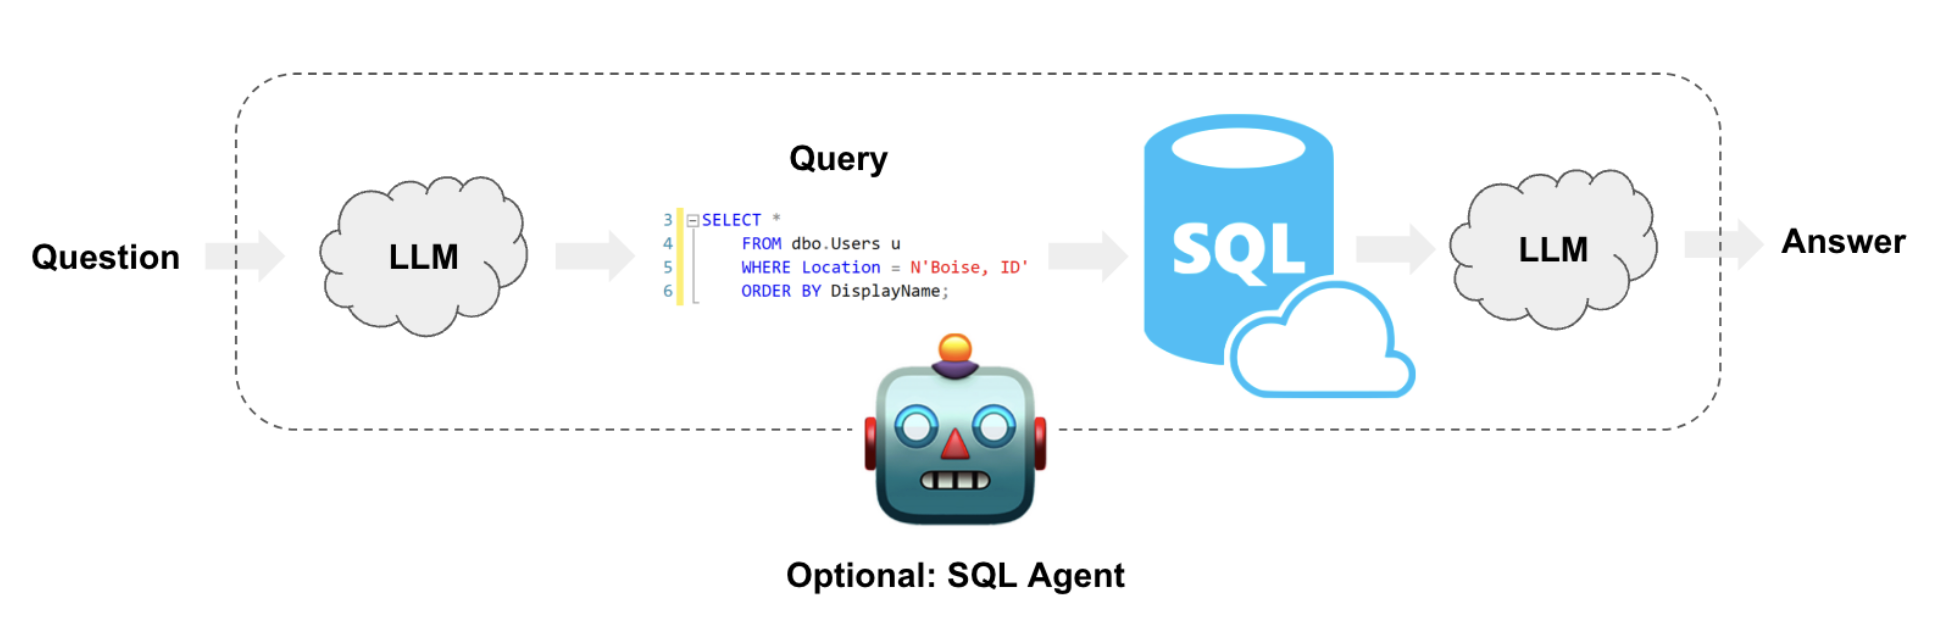

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
## Langsmith Tracking
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")

In [3]:
from langchain.chat_models import init_chat_model
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
import requests

In [4]:
llm = init_chat_model("openai:gpt-4.1")
llm

ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x10b0c4d70>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x10b0c57f0>, root_client=<openai.OpenAI object at 0x10a5d7380>, root_async_client=<openai.AsyncOpenAI object at 0x10b0c4ec0>, model_name='gpt-4.1', model_kwargs={}, openai_api_key=SecretStr('**********'))

In [5]:
# Try to connect to the database with different paths
import os

# Define possible database paths
possible_db_paths = [
    # 'boiler_data_all_sheets.db',  # Current directory
    '/Users/kush/Desktop/Gen AI Assignement Cerebulb/boiler_data_all_sheets.db',  # Parent directory
    os.path.join('..', 'boiler_data_all_sheets.db'),  # Alternative parent directory syntax
    os.path.abspath('boiler_data_all_sheets.db'),  # Absolute path current dir
    os.path.abspath(os.path.join('..', 'boiler_data_all_sheets.db'))  # Absolute path parent dir
]

# Try each path
for db_path in possible_db_paths:
    if os.path.exists(db_path):
        print(f"Found database at: {db_path}")
        try:
            # Try to connect with SQLDatabase
            db = SQLDatabase.from_uri(f"sqlite:///{db_path}")
            tables = db.get_usable_table_names()
            
            print(f"Dialect: {db.dialect}")
            if tables:
                print("Available tables:")
                for table in tables:
                    print(f"- {table}")
                # If we found tables, break the loop
                break
            else:
                print("No tables found in this database.")
        except Exception as e:
            print(f"Error connecting to database at {db_path}: {str(e)}")
    else:
        print(f"Database file not found at: {db_path}")

Found database at: /Users/kush/Desktop/Gen AI Assignement Cerebulb/boiler_data_all_sheets.db
Dialect: sqlite
Available tables:
- boiler_bol2
- boiler_bolr_1
- boiler_bolr_3
- boiler_data
- monthly_stats
- weekly_stats


In [6]:
print(f'Sample output: {db.run("SELECT * FROM boiler_bolr_1 LIMIT 1;")}')

Sample output: [('2024-04-01 00:00:00.000000', 0.0, 1489, 1300.6261740742507, 188.37382592574932, 0.1922091235263967, 1300.4339649507242, 0.0, 885, 24, 0, 0, 0, 0, 10.17, 2.7, 2.2, 127.5, 119.4, 29.2, 82.52, 155.8, 101.75, 26.4375, 6.779, 29.30000000000001, 23.99, 10.17, 36.54, 3902, 41.538768388099996, 3.0232189383, 0.47961000000000004, 1.8121200000000002, 6.436282673600006, 2.45, 17.8, 5.9139146567718, 192.487, 247.2934, 34.3801, 27.9036, 33.2, 123.45, 13.486085343228199, 50, 60, 10, 6.738, 16.738, 0.0016738, 5.59, 1.86, 900, 123.45, 16.0, 0.2999940001199976, 0.022108138699871965, 5.611462062246399, 39.20112157808004, 7.811218127575447, 8.071383427489108, 4.480424526894262, 1.6279623590466428, 4.324986573687069, 0.17973944877282327, 0.007588300895165009, 1.2661548255253716, 0.42280797339825726, 1.6889627989236289, 0.1606019911360385, 0.41509092952010984, 0.5756929206561483, 0.65, 13.53535692887574, 86.46464307112426, 0.13838592600048844, 0.09953832839195971, 0.5, 85.7267188167318, 54

### Tools for database interactions

langchain-community implements some built-in tools for interacting with our SQLDatabase, including tools for listing tables, reading table schemas, and checking and running queries

In [7]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



LangChain provides a toolkit with several built-in tools for SQL agents:

sql_db_list_tables: Lists all tables in the database.

sql_db_schema: Retrieves schema and sample rows for specified tables.

sql_db_query: Executes a given SQL query and returns results.

sql_db_query_checker: Validates the syntax of a SQL query before execution.

## 2. Using a prebuilt agent

Given these tools, we can initialize a pre-built agent in a single line. To customize our agents behavior, we write a descriptive system prompt.

In [8]:
from langgraph.prebuilt import create_react_agent

system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

agent = create_react_agent(
    llm,
    tools,
    prompt=system_prompt,
)

#### 🧠 What Is a ReAct Agent?

A **ReAct agent** in LangChain is an agent that uses the **"ReAct" (Reasoning and Acting)** prompting framework, which allows large language models (LLMs) to alternate between thinking (reasoning) and acting (using tools or APIs) in an iterative loop.



#### 🔍 Key Origins

- Introduced in the research paper **"ReAct: Synergizing Reasoning and Acting in Language Models"**
- Widely used for building **complex, multi-step task-solving agents**
- Combines **logical reasoning** with **real-world actions**



#### ⚙️ How Does a ReAct Agent Work?

##### Thought/Action/Observation Loop

The agent follows a cyclical process with three key stages:

1. **Thought**: Reason about the next step  
2. **Action**: Decide which tool or action to use  
3. **Observation**: Execute the action and analyze the result  



#### 🔁 Characteristics of the Loop

- **Iterative**: Repeats until a final answer is reached
- **Flexible**: Can use various tools like:
  - Database searches
  - API calls
  - External information retrieval
  - Computational tools



#### 🧾 Prompt Structure Example

```text
Question: [user input]  
Thought: [agent's reasoning]  
Action: [chosen tool or action]  
Action Input: [input to the tool]  
Observation: [result from the tool]  
... (repeat as needed)  
Thought: I now know the final answer  
Final Answer: [final answer]  



#### Understanding prompt

1) Purpose: Help users get information from a database by writing and running SQL queries.

2) Key Rules:
- Always start by looking at the available tables in the database
-  the structure (schema) of the most relevant tables
- Write queries that are syntactically correct
- Only select the specific columns needed to answer the question
- Limit the number of results (default to a small number like top 5 or 10)
- Try to order results to get the most interesting or relevant information
- If a query fails, try to fix and rerun it

3) Important Restrictions:
- Do NOT modify the database (no INSERT, UPDATE, DELETE, or DROP commands)
- Only retrieve information, never change anything


Goal: Provide accurate, concise, and relevant information from the database by writing smart, targeted SQL queries.

Let's run this agent on a sample query and observe its behavior:

In [9]:
question = "What was the value of Coal ConsumptionKPI on date 4-1-24? for Boiler 1? "

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What was the value of Coal ConsumptionKPI on date 4-1-24? for Boiler 1? 


APIConnectionError: Connection error.

Failed to get info from https://api.smith.langchain.com: LangSmithConnectionError('Connection error caused failure to GET /info in LangSmith API. Please confirm your internet connection. ConnectionError(MaxRetryError(\'HTTPSConnectionPool(host=\\\'api.smith.langchain.com\\\', port=443): Max retries exceeded with url: /info (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x10e06f890>: Failed to resolve \\\'api.smith.langchain.com\\\' ([Errno 8] nodename nor servname provided, or not known)"))\'))\nContent-Length: None\nAPI Key: lsv2_********************************************d3')


In [ ]:
question = "What is the value of Difference of Coal KPI to equivalent Coal KPI at Coal ConsumptionKPI = 1296.01 for 3rd April 2024 for boiler ? "

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the value of Difference of Coal KPI to equivalent Coal KPI at Coal ConsumptionKPI = 1296.01 for 3rd April 2024 for boiler ? 
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_0UcEPi0unRDHYsVEMdlMicfi)
 Call ID: call_0UcEPi0unRDHYsVEMdlMicfi
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

boiler_bol2, boiler_bolr_1, boiler_bolr_3, boiler_data, monthly_stats, weekly_stats
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_LM8iPFsuS2iZiXXYjydQ8386)
 Call ID: call_LM8iPFsuS2iZiXXYjydQ8386
  Args:
    table_names: boiler_data
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE boiler_data (
	"Date" DATETIME, 
	"LDO Consumption

In [ ]:
question = "who is the richest person in the world?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

who is the richest person in the world?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_CdKseCLRy2PBKKot5VwmUpB6)
 Call ID: call_CdKseCLRy2PBKKot5VwmUpB6
  Args:
================================= Tool Message =================================
Name: sql_db_list_tables

boiler_bol2, boiler_bolr_1, boiler_bolr_3, boiler_data, monthly_stats, weekly_stats
================================== Ai Message ==================================

It appears that the database available does not have standard tables that would typically store information about the wealth of individuals (such as "people", "net_worth", or "billionaires"). The listed tables relate to "boiler" data and some statistics, none of which suggest the presence of information on the richest person in the world.

If you have a different database or additional data, please provide m

In [ ]:
question = "What is the value of CO2 APH O/L for Flue Gas temp APH O/L = 123.35 and Weighted Air I/L temp to APH = 33.2 for 1st April 2024 for boiler 2"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

What is the value of CO2 APH O/L for Flue Gas temp APH O/L = 123.35 and Weighted Air I/L temp to APH = 33.2 for 1st April 2024 for boiler 2
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_uUnjpva5TgdIXwmcteNTMAVg)
 Call ID: call_uUnjpva5TgdIXwmcteNTMAVg
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

boiler_bol2, boiler_bolr_1, boiler_bolr_3, boiler_data, monthly_stats, weekly_stats
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_4dULCxE488OUQgiDgD4rJMF2)
 Call ID: call_4dULCxE488OUQgiDgD4rJMF2
  Args:
    table_names: boiler_bol2, boiler_data
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE boiler_bol2 (
	"Date" DATETIME

In [ ]:
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode


get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}

## Instructs the agent to generate a SQL query based on the user’s question and database schema.

generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}

# Instructs the agent to validate the generated SQL query for common mistakes before execution.

check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

##### We construct dedicated nodes for the following steps:

1) Listing DB tables
2) Calling the "get schema" tool
3) Generating a query
4) Checking the query


In [ ]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

agent = builder.compile()

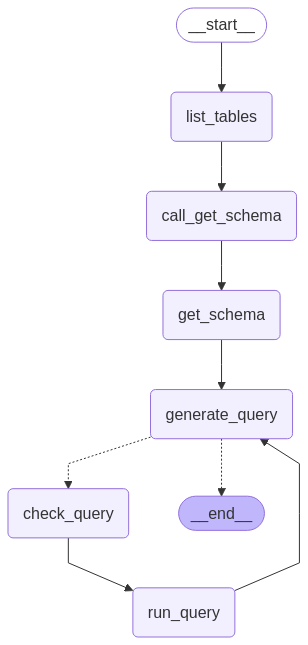

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [ ]:
question = "What is the value of CO2 APH O/L for Flue Gas temp APH O/L = 123.35 and Weighted Air I/L temp to APH = 33.2 for 1st April 2024 for boiler 2"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

NameError: name 'agent' is not defined

In [ ]:
question = "who is the richest person in the world?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

who is the richest person in the world?
================================== Ai Message ==================================

Available tables: boiler_bol2, boiler_bolr_1, boiler_bolr_3, boiler_data, monthly_stats, weekly_stats
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_B02TlUeF38uZ7AW42fk5NA9E)
 Call ID: call_B02TlUeF38uZ7AW42fk5NA9E
  Args:
    table_names: boiler_bol2, boiler_bolr_1, boiler_bolr_3, boiler_data, monthly_stats, weekly_stats
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE boiler_bol2 (
	"Date" DATETIME, 
	"LDO Consumption(kl)" FLOAT, 
	"Coal ConsumptionFeeder(MT)" FLOAT, 
	"Coal ConsumptionKPI" FLOAT, 
	"Difference Coal Feeder Vs KPI" FLOAT, 
	"Equivalent Coal Consumption due to HFO Consumption" FLOAT, 
	"Difference of Coal KPI to equivalent Coal KPI" FLO